## Question 1

#### Load  CIFAR-10 dataset batches and merge 

In [204]:
import pickle

# Initialize lists to store data
data = []
labels = []

# Loop through each file in the dataset
for i in range(1, 6):
    # Open the file and load the data
    with open(f'data_batch_{i}', 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
        
    # Extract the data and labels from the file
    batch_data = dict[b'data']
    batch_labels = dict[b'labels']
    # Append the data and labels to the overall lists
    
    data.append(batch_data)
    labels.append(batch_labels)

# Combine the data and labels into a single array
data = np.concatenate(data)
labels = np.concatenate(labels)



## Question 2

#### Implement the image transformation methods 

In [189]:
X_train = data.reshape(len(data),3, 32, 32)
X_train = X_train.transpose((0,2, 3, 1))
image=X_train[1]
y_train=labels


In [208]:
def img_enhancement(x):
    min_pixel=x.min()
    max_pixel=x.max()
    image_array =( (x - min_pixel) / (max_pixel - min_pixel) )*255
    image = image_array.astype(np.uint8)/255.0
    return image

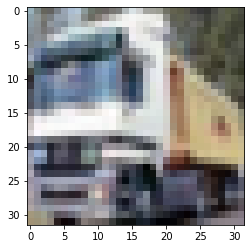

In [209]:
img_enhance=img_enhancement(image)

plt.imshow(img_enhance)
plt.show()

In [162]:
def img_posterization(image):  
    min_pixel = 100
    max_pixel = 200

    # Calculate the range
    Range = max_pixel - min_pixel

    # Get the divider for the colors
    divider = 255 / Range    
    image=image/divider
    image+=min_pixel
    out_array = np.clip(image, a_min =0, a_max = 255,out=None) 
    image = out_array.astype(np.uint8)/255.0
    return image


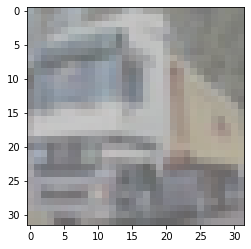

In [163]:
img_post=img_posterization(image)

plt.imshow(img_post)
plt.show()

In [164]:
def rotation(image): 
    (height, width, channels) = image.shape

        # Create a blank image of the same size as the original
    rotated_img = np.zeros((height, width, channels), np.uint8)

        # Define the angle of rotation
    theta = random.uniform(-180, 180)

    shift_origin_x=width/2;
    shift_origin_y=height/2;

        # For each pixel in the original image
    for x in range(width):
            for y in range(height):
                x_new=x-shift_origin_x;
                y_new=y-shift_origin_y;
                # Calculate the new position of the pixel in the rotated image
                new_x = int(x_new * np.cos(theta) - y_new * np.sin(theta))
                new_y = int(x_new * np.sin(theta) + y_new * np.cos(theta))

                new_x+=shift_origin_x;
                new_y+=shift_origin_y;
                # Check if the new position is within the bounds of the rotated image
                if new_x >= 0 and new_x < width and new_y >= 0 and new_y < height:
                    # Copy the pixel to the new position
                    rotated_img[int(new_y)][int(new_x)] = image[y][x]
    return rotated_img

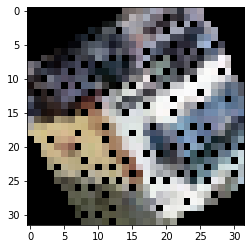

In [165]:
rotated_image=rotation(image)
plt.imshow(rotated_image)
plt.show()


In [166]:
def contrast_and_flip(image, prob=0.5):
    # Change contrast
    alpha = np.random.uniform(0.5, 2.0)
    image = alpha * (image - 128) + 128
    image = np.clip(image, 0, 255).astype(np.uint8)
    
    
    # Flip image horizontally with probability prob
    if np.random.random() < prob:
        image = np.fliplr(image)
    
    return image

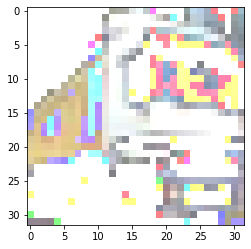

In [167]:
contrast_img=contrast_and_flip(image)
plt.imshow(contrast_img)
plt.show()

## Question 3

#### Create the augmented training set using the transformation functions

In [192]:


# list to store augmented images
X_augmented = []
y_augmented=[]

# iterate over each image in original training set
for i  in range (len(data)):
    img=X_train[i]
    label=y_train[i]
        
    # randomly select one of the four transformation functions
    rand_num = np.random.randint(0, 4)
    if rand_num == 0:
        # apply img_enhacement
        img_aug=img_enhancement(img)
        
    elif rand_num == 1:
        # apply posterization
        img_aug=img_posterization(img)
        
    elif rand_num == 2:
        # apply rotation
        img_aug=rotation(img)
        
    else:
        # apply contrast and flipping
        img_aug = contrast_and_flip(img)

    # add augmented image to list
    
    X_augmented.append(img_aug.reshape(3072))
    y_augmented.append(label)
    
# combine original training set with augmented images
X_augmented_train = np.concatenate((data, X_augmented), axis=0)
y_augmented_train = np.concatenate((labels, y_augmented), axis=0)

print(np.shape(X_train))
np.shape(X_augmented_train)

(50000, 32, 32, 3)


(100000, 3072)

## Question 4

#### feature extraction by feature_extractor

In [212]:
from feature_extractor import BBResNet18

# Initialize the feature extractor
extractor =BBResNet18()

In [213]:
# code for feature extraction of original dataset

In [215]:
import cv2
import random
rand_indices = np.random.permutation(data.shape[0])
feature_list=[]
# Loop over the random indices to process the images one by one
for i in rand_indices:
    image = data[i, :]
    image_array = np.reshape(image, (32, 32, 3))
    resized_image = cv2.resize(image_array, (224,224))
    resized_image = np.transpose(resized_image, (2,0,1))
    img = np.array(resized_image, dtype=np.float32)
    img = np.expand_dims(img, axis=0)
    feature_list.append(extractor.feature_extraction(img))
    

In [216]:
feature=np.array(feature_list)
feature=feature.squeeze()

In [217]:
# normalize feature vector by max-min scaling

min_values = np.min(feature, axis=0)
max_values = np.max(feature, axis=0)

normalized_feature = (feature - min_values) / (max_values - min_values+1e-10)


In [218]:
with open("normalized_featuref.pkl","wb") as file:
    pickle.dump(normalized_feature,file);

In [219]:
final_labels=[]
for i in range(len(rand_indices)):
    final_labels.append(labels[rand_indices[i]])
    


In [220]:
with open("finallabelsf.pkl","wb") as file:
    pickle.dump(final_labels,file);

In [221]:
import cv2
import random

rand_indices = np.random.permutation(X_augmented_train.shape[0])
feature_list=[]
# Loop over the random indices to process the images one by one
for i in rand_indices:
    image = X_augmented_train[i, :]
    image_array = np.reshape(image, (32, 32, 3))
    resized_image = cv2.resize(image_array, (224,224))
    resized_image = np.transpose(resized_image, (2,0,1))
    img = np.array(resized_image, dtype=np.float32)
    img = np.expand_dims(img, axis=0)
    feature_list.append(extractor.feature_extraction(img))
    

In [222]:
feature=np.array(feature_list)
feature=feature.squeeze()


In [223]:
# normalize feature vector by max-min scaling

min_values = np.min(feature, axis=0)
max_values = np.max(feature, axis=0)

normalized_feature = (feature - min_values) / (max_values - min_values+1e-10)


In [224]:
with open("normalized_feature_aug.pkl","wb") as file:
    pickle.dump(normalized_feature,file);

In [225]:
final_labels=[]
for i in range(len(rand_indices)):
    final_labels.append(y_augmented_train[rand_indices[i]])
    


In [226]:
with open("finallabels_aug.pkl","wb") as file:
    pickle.dump(final_labels,file);

In [227]:
# feature extraction for test file

In [228]:
import numpy as np
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        X = dict[b'data']
        Y = dict[b'labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y
    
    
test_data,test_labels=unpickle('test_batch')

In [237]:
import cv2
def get_features(y):
    feature_list =[]
    for i in range(len(y)):
        image_array = np.reshape(y[i], (32, 32, 3))
        resized_image = cv2.resize(image_array, (224,224))
        resized_image = np.transpose(resized_image, (2,0,1))
        image = np.array(resized_image, dtype=np.float32)
        image = np.expand_dims(image, axis=0)
        feature_list.append(extractor.feature_extraction(image))
    return feature_list

In [229]:
test_feature=get_features(test_data)

In [231]:
test_feature=np.array(test_feature)
test_feature=test_feature.squeeze()


In [232]:
# normalize feature vector by max-min scaling

min_values = np.min(test_feature, axis=0)
max_values = np.max(test_feature, axis=0)

normalized_feature_test = (test_feature - min_values) / (max_values - min_values+1e-10)


In [233]:
with open("test_featuref.pkl","wb") as file:
    pickle.dump(final_labels,file);